In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch
import torch.nn.functional as F



In [13]:
words = open('names.txt', 'r').read().splitlines()

for word in words[:10]:
  print(word)

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


vocab_size = len(itos)


emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn


In [ ]:
def build_dataset(words, block_size):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

def build_loos(C, X, Y, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running, print_label=""):
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    if print_label:
        print(print_label, loss.data)
    return emb, h, logits, loss

# Made it clean
block_size = 3  
batch_size = 32
n_embd = 10
n_hidden = 200
max_steps = 200000

# splits of training, dev and test
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size)
Xte, Yte = build_dataset(words[n2:], block_size=block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

lossi = []
for i in range(max_steps):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    if i % 10000 == 0:
       print_label = f"step {i}"
    else:
       print_label = ""
    _, _, _, loss = build_loos(C, Xtr[ix], Ytr[ix], W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running, print_label=print_label)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())

# last forward pass
emb, h, logits, loss = build_loos(C, Xdev, Ydev, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running, print_label="dev")


step 0 tensor(3.2971)
step 10000 tensor(2.3343)
step 20000 tensor(2.0105)
step 30000 tensor(2.5551)
step 40000 tensor(2.0118)
step 50000 tensor(2.2107)
step 60000 tensor(1.8982)
step 70000 tensor(2.2390)
step 80000 tensor(2.3456)
step 90000 tensor(2.2562)
step 100000 tensor(2.2287)
step 110000 tensor(2.0595)
step 120000 tensor(2.2865)
step 130000 tensor(2.1591)
step 140000 tensor(2.4247)
step 150000 tensor(1.9715)
step 160000 tensor(2.3370)
step 170000 tensor(2.0409)
step 180000 tensor(2.3950)
step 190000 tensor(2.3701)
dev tensor(2.1107)


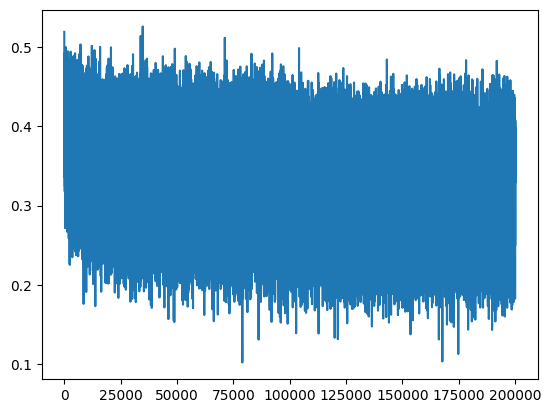

In [4]:
plt.plot(lossi)

In [10]:
# Sampling from neural network model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    context = [0] * block_size
    out = []
    while True:
        
        # Get current context
        emb = C[torch.tensor([context])] # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)
        # Linear layer
        hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1)

        # Sample
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

        # Update context
        context = context[1:] + [ix]

    print("".join(out))

tex.
marlaz.
mikillistavisha.
kejtna.
nell.
dez.
kezr.
samridabrathrightsk.
khzir.
khao.


In [6]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [24]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

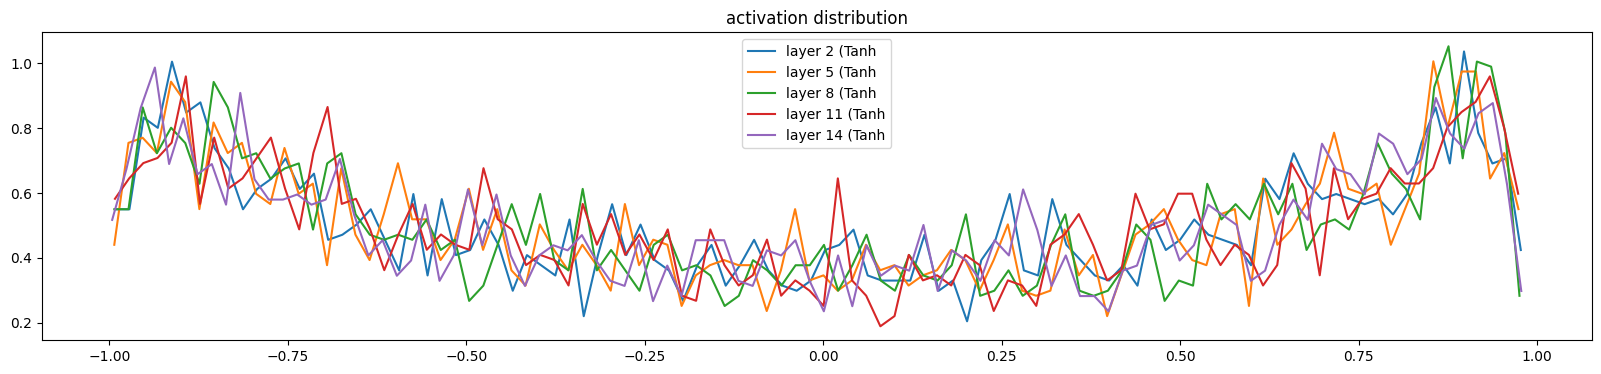

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('fordward: activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.860916e-03
layer 5 (      Tanh): mean -0.000000, std 3.310031e-03
layer 8 (      Tanh): mean -0.000000, std 3.105930e-03
layer 11 (      Tanh): mean -0.000000, std 2.750410e-03
layer 14 (      Tanh): mean -0.000000, std 2.485620e-03


Text(0.5, 1.0, 'gradient distribution')

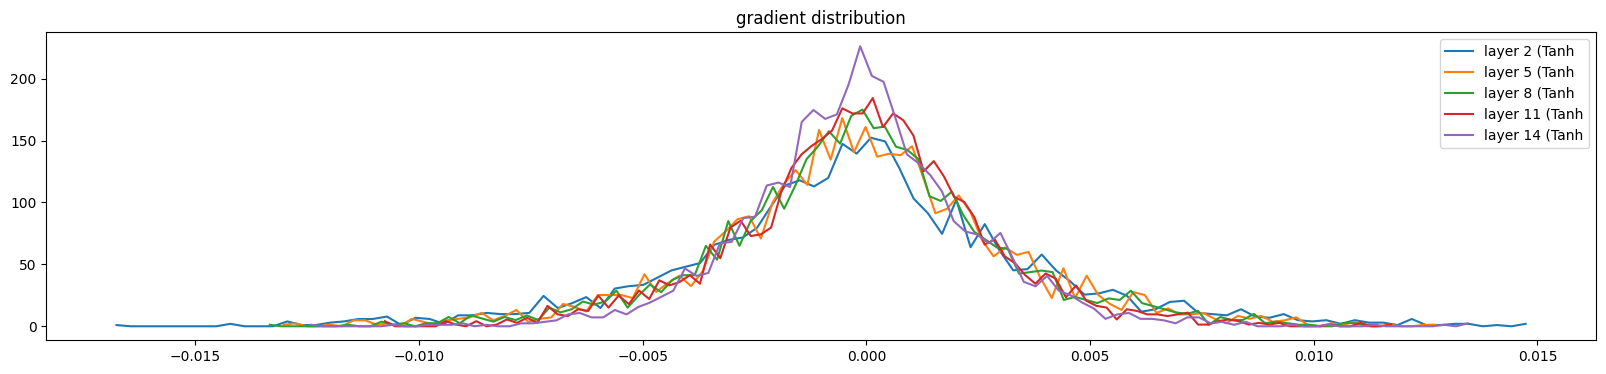

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('backward: gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.878525e-03 | grad:data ratio 9.868571e-03
weight  (30, 100) | mean -0.000094 | std 8.747961e-03 | grad:data ratio 2.799227e-02
weight (100, 100) | mean +0.000160 | std 7.655444e-03 | grad:data ratio 4.581045e-02
weight (100, 100) | mean +0.000066 | std 6.817398e-03 | grad:data ratio 4.043710e-02
weight (100, 100) | mean +0.000010 | std 6.177770e-03 | grad:data ratio 3.681592e-02
weight (100, 100) | mean +0.000014 | std 5.331900e-03 | grad:data ratio 3.176154e-02
weight  (100, 27) | mean -0.000046 | std 9.655396e-03 | grad:data ratio 5.796683e-02


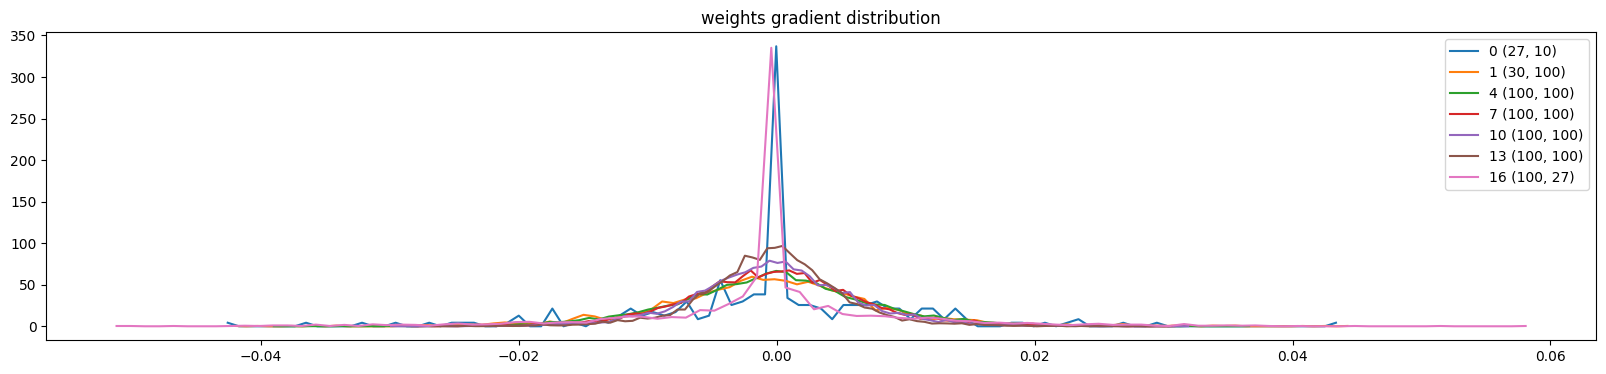

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

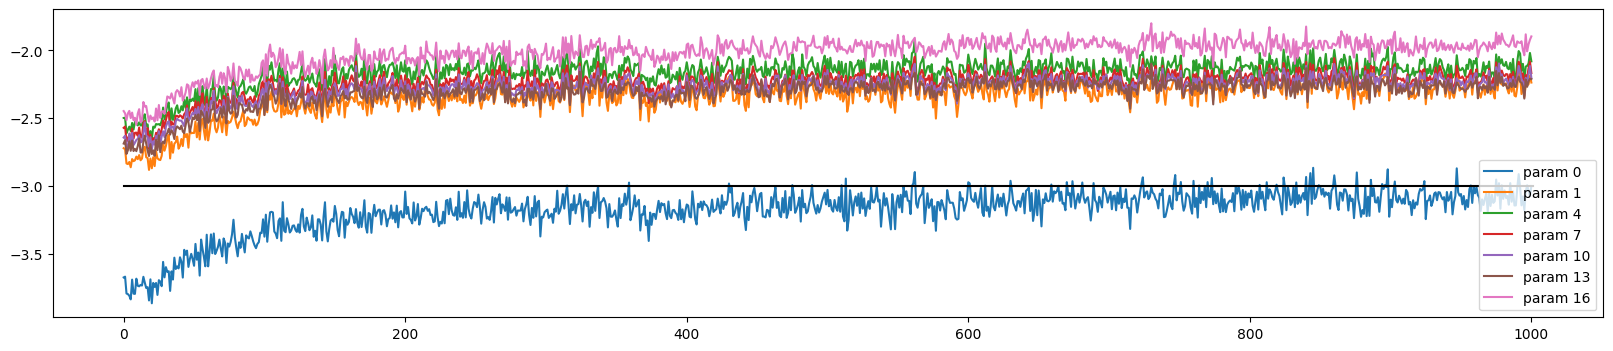

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);